In [11]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [12]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="John")]
messages.extend([HumanMessage(content=f"Yes thats rigght", name="Jane")])
messages.extend([AIMessage(content=f"Great what would you like to know more?", name="John")])
messages.extend([HumanMessage(content=f"Tell me about dolphins", name="Jane")])

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: John

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Jane

Yes thats rigght
================================== Ai Message ==================================
Name: John

Great what would you like to know more?
================================ Human Message =================================
Name: Jane

Tell me about dolphins


## Chat Models
They can use a sequence of messages as input and support message roles as discussed above

In [13]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [14]:
# os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [15]:
import getpass

def _set_env(variable: str):
    if not os.environ.get(variable):
        os.environ[variable] = getpass.getpass(f"Enter {variable}: ")

_set_env("GROQ_API_KEY")

In [17]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")
result = llm.invoke("Hello")
type(result)

langchain_core.messages.ai.AIMessage

In [21]:
print(result)

content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?" response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.021666667, 'prompt_time': 0.001022051, 'queue_time': 0.017200479, 'total_time': 0.022688718}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_af05557ca2', 'finish_reason': 'stop', 'logprobs': None} id='run-7a017eac-c618-4b74-a5a5-224d3322e776-0'


In [22]:
result.response_metadata

{'token_usage': {'completion_tokens': 26,
  'prompt_tokens': 11,
  'total_tokens': 37,
  'completion_time': 0.021666667,
  'prompt_time': 0.001022051,
  'queue_time': 0.017200479,
  'total_time': 0.022688718},
 'model_name': 'llama3-8b-8192',
 'system_fingerprint': 'fp_af05557ca2',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are useful whenever we want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
 can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [25]:
def multiply(a: int, b: int) -> int:
    """
    Multiply two number together
    
    Args:
        a : First number
        b : Second number
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [26]:
tool_call = llm_with_tools.invoke(
    [HumanMessage(content="What is 2 times 3?", name="Jane")]
)
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cp22', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 939, 'total_tokens': 1018, 'completion_time': 0.065833333, 'prompt_time': 0.116680854, 'queue_time': 0.0022716750000000008, 'total_time': 0.182514187}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2e8b9574-6ed9-4e0c-96f6-443416b49374-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_cp22', 'type': 'tool_call'}])

In [27]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_cp22',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [31]:
from typing import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [36]:
## We want to append messages to our messages state key not override it. so it stores a full history of conversation

from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [37]:
# from langgraph.graph import MessagesState

# class State(MessagesState):
#     # add any keys needed which is prebuilt

In [38]:
# initial state
initial_messages = [
    AIMessage(content="Hello how can i assist you?", name="John"),
    HumanMessage(content="I would like to know more about dolphins", name="Jane"),
]
new_message = AIMessage(content="Dolphins are mammals that live in the ocean", name="John")

# testing
add_messages(initial_messages, new_message)

[AIMessage(content='Hello how can i assist you?', name='John', id='c4a21c5c-2d0c-4a9a-97c8-5f7e20356805'),
 HumanMessage(content='I would like to know more about dolphins', name='Jane', id='1796018c-98c5-4deb-b76c-e6759e19cab1'),
 AIMessage(content='Dolphins are mammals that live in the ocean', name='John', id='d425ed4a-d844-4dad-849e-90e6d3a4beb2')]

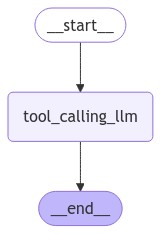

In [39]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
messages = graph.invoke({"messages": HumanMessage(content="Hey")})

In [45]:
messages

{'messages': [HumanMessage(content='Hey', id='2afb2caa-1989-41f2-a2a2-b8e6565110d2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_knga', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 932, 'total_tokens': 1004, 'completion_time': 0.06, 'prompt_time': 0.113931574, 'queue_time': 0.0020850240000000048, 'total_time': 0.173931574}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11349f1b-f106-4513-be48-cdceb5429fce-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_knga', 'type': 'tool_call'}])]}

In [57]:
messages["messages"]

[HumanMessage(content='Hey', id='2afb2caa-1989-41f2-a2a2-b8e6565110d2'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_knga', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 932, 'total_tokens': 1004, 'completion_time': 0.06, 'prompt_time': 0.113931574, 'queue_time': 0.0020850240000000048, 'total_time': 0.173931574}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11349f1b-f106-4513-be48-cdceb5429fce-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_knga', 'type': 'tool_call'}])]

In [58]:
messages = graph.invoke({"messages": HumanMessage(content="What is 2 times 3?", name="Jane")})

In [60]:
messages
## Message is here a tool call

{'messages': [HumanMessage(content='What is 2 times 3?', name='Jane', id='456ba56e-0b5c-4740-af90-6b758c21870f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_33jb', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 939, 'total_tokens': 1011, 'completion_time': 0.06, 'prompt_time': 0.114613576, 'queue_time': 0.00179949900000001, 'total_time': 0.174613576}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f50c492-32ac-4e40-ab94-dc084b39f133-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_33jb', 'type': 'tool_call'}])]}

In [62]:
messages = graph.invoke({"messages": HumanMessage(content="Hey", name="Jane")})

In [63]:
messages

{'messages': [HumanMessage(content='Hey', name='Jane', id='8422bcb1-1e93-4dc2-9fca-262db4d42f85'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b1q3', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 932, 'total_tokens': 1004, 'completion_time': 0.06, 'prompt_time': 0.114307891, 'queue_time': 0.002400474999999999, 'total_time': 0.174307891}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_af05557ca2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4ea4a97a-bc81-4911-8a64-2befe117e56a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_b1q3', 'type': 'tool_call'}])]}